# CIFAR-10 Baseline model

In [1]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

# importing of service libraries
import numpy as np
import matplotlib.pyplot as plt

print('Libraries imported.')

2023-04-10 01:58:24.792382: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Libraries imported.


In [2]:
import random
import tensorflow as tf
import os


def set_seed(seed=42):
    '''
    Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.
    '''
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed()

## Data preprocessing

In [3]:
# CIFAR_10 is a set of 60K images 32x32 pixels on 3 channels
IMG_CHANNELS = 3
IMAGE_SIZE = 32

print('Image variables initialisation')

Image variables initialisation


In [4]:
(input_X_train, output_y_train),(input_X_test, output_y_test)=cifar10.load_data()

print('input_X_train shape: ', input_X_train.shape)
print(input_X_train.shape[0], 'train samples')
print(input_X_test.shape[0], 'test samples')

input_X_train shape:  (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [5]:
N_CLASSES =len(np.unique(output_y_train))

In [6]:
# output data one-hot encoding 
output_y_train=utils.to_categorical(output_y_train, N_CLASSES)
output_y_test=utils.to_categorical(output_y_test, N_CLASSES)

In [7]:
# To normalize the value in between 0 and 1 (there are 255 kinds)
input_X_train=input_X_train.astype('float32')
input_X_test=input_X_test.astype('float32')

input_X_train /=255
input_X_test /=255

/Users/jeongdahye/opt/anaconda3/lib/python3.8/site-packages/matplotlib/text.py:1241: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


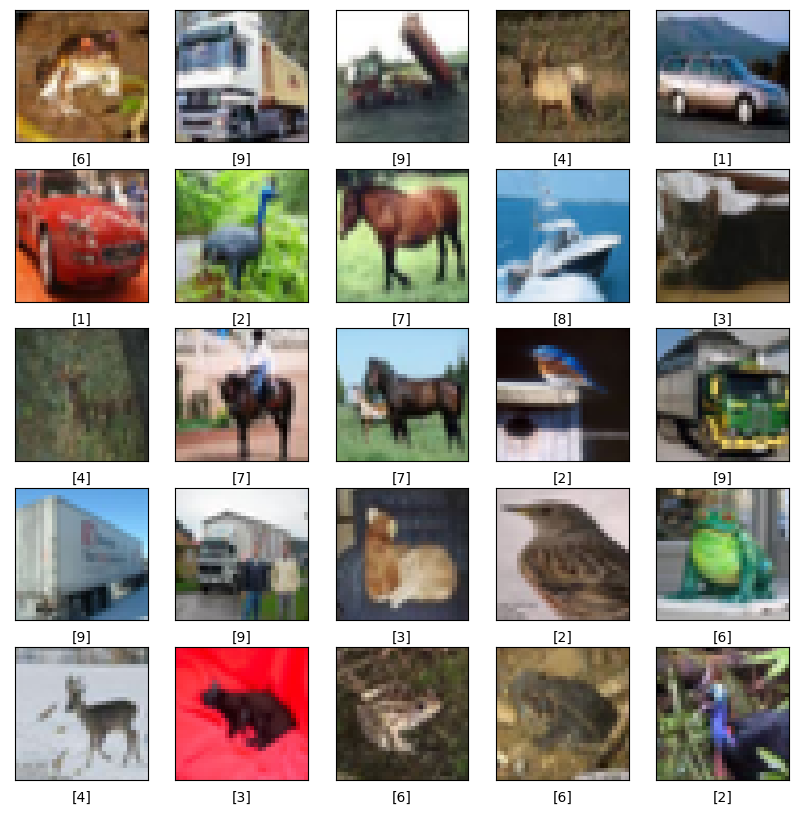

In [8]:
plt.figure(figsize=(10,10)) 

for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(input_X_train[i], cmap="gray")
  plt.xlabel(np.where(output_y_train[i] == 1)[0])

plt.show()


In [9]:
#Define the function for plotting the history of the training of the model
def plot_history(history):
    val_loss = history.history['val_loss' ]
    loss =     history.history['loss' ]
    acc =      history.history['accuracy' ]
    val_acc =  history.history['val_accuracy' ]

    epochs    = range(1,len(acc)+1,1)

    plt.plot  ( epochs,     acc, 'r--', label='Training acc'  )
    plt.plot  ( epochs, val_acc,  'b', label='Validation acc')
    plt.title ('Training and validation accuracy')
    plt.ylabel('acc')
    plt.xlabel('epochs')
    plt.legend()

    plt.figure()

    plt.plot  ( epochs,     loss, 'r--', label='Training loss' )
    plt.plot  ( epochs, val_loss ,  'b', label='Validation loss' )
    plt.title ('Training and validation loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend()

    plt.figure()

### Data augmentation

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen=ImageDataGenerator(rotation_range=40, 
                           width_shift_range=0.2, 
                           height_shift_range=0.2, 
                           zoom_range=0.2, 
                           horizontal_flip=True, 
                           fill_mode='nearest')

# rotation_range is a value in degrees (0 - 180) for randomly rotating pictures
# width_shift and height_shift are ranges for randomly translating pictures vertically or horizontally
# zoom_range is for randomly zooming pictures 
# horizontal_flip is for randomly flipping the images horizontally
# fill_mode fills in new pixels that can appear after a rotation or a shift

# Generate augmented images
batch_size = 32
input_X_train_aug = np.zeros_like(input_X_train)

for i, batch in enumerate(datagen.flow(input_X_train, batch_size=batch_size)):
    input_X_train_aug[i*batch_size:(i+1)*batch_size] = batch
    if (i+1)*batch_size >= len(input_X_train):
        break

In [11]:
print(input_X_train_aug.shape)

(50000, 32, 32, 3)


## Hyper parameter Trial 1

In [12]:
#training constants
BATCH_SIZE1 = 128
N_EPOCH1 = 20 # use 20 for best initial results
VERBOSE1 = 1
VALIDATION_SPLIT1 = 0.2
learning_rate1 = 0.01
OPTIM1 = RMSprop(learning_rate = learning_rate1)
KERNEL = (3,3)

print('Main variables initialised.')

Main variables initialised.


### Simple Model

In [17]:
#Simpler Model

model=Sequential()
model.add(Conv2D(32, KERNEL, padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, IMG_CHANNELS)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(N_CLASSES))
model.add(Activation('softmax'))

print('CNN Network Definition setup')

CNN Network Definition setup


#### Without Data Augmentation

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 activation_18 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_11 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 flatten_5 (Flatten)         (None, 8192)              0         
                                                                 
 dense_10 (Dense)            (None, 512)               4194816   
                                                      

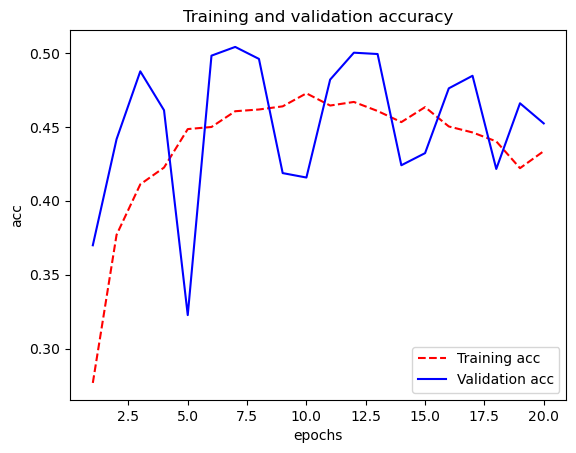

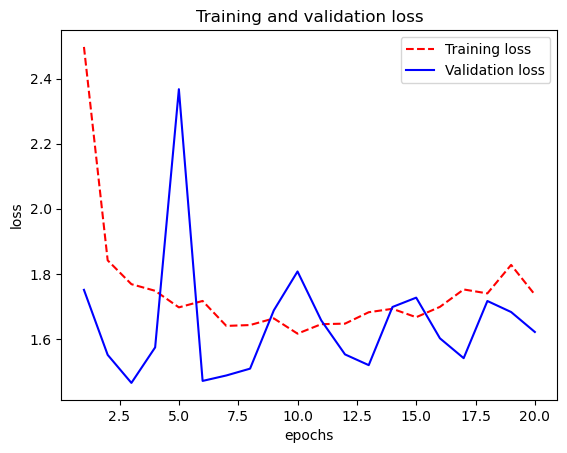

<Figure size 640x480 with 0 Axes>

In [65]:
model.compile(loss='categorical_crossentropy', optimizer=OPTIM1, metrics=['accuracy'])
model.summary()

history=model.fit(input_X_train, output_y_train, batch_size=BATCH_SIZE1, 
                  epochs=N_EPOCH1, validation_split=VALIDATION_SPLIT1, verbose=VERBOSE1)


plot_history(history)
test_loss,test_acc=model.evaluate(input_X_test, output_y_test, verbose=2)

print("test accuracy: ",test_acc)

#### With Data Augmentation

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 activation_3 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               4194816   
                                                      

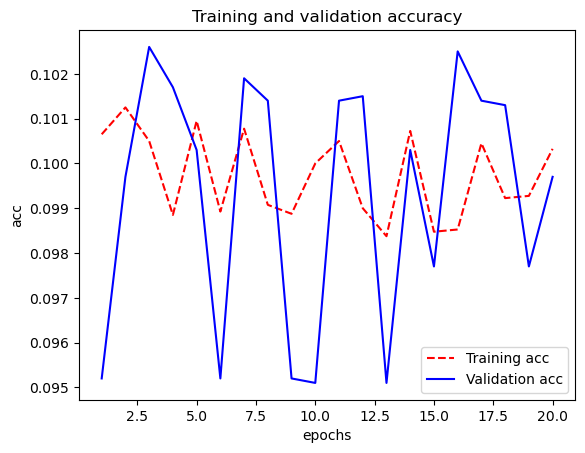

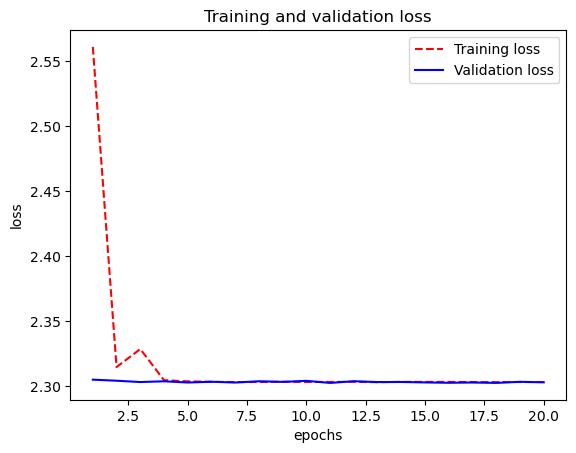

<Figure size 640x480 with 0 Axes>

In [18]:
# Result with data augmentation
model.compile(loss='categorical_crossentropy', optimizer=OPTIM1, metrics=['accuracy'])
model.summary()

history=model.fit(input_X_train_aug, output_y_train, batch_size=BATCH_SIZE1, 
                  epochs=N_EPOCH1, validation_split=VALIDATION_SPLIT1, verbose=VERBOSE1)


plot_history(history)
test_loss,test_acc=model.evaluate(input_X_test, output_y_test, verbose=2)

print("test accuracy: ",test_acc)

### Complex CNN

In [13]:
# Complex DNN model definition
model = Sequential()

# hidden 1 : conv + conv + pool + dropout 
model.add(Conv2D(32, KERNEL, padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, IMG_CHANNELS)))
model.add(Activation('relu'))
model.add(Conv2D(32, KERNEL, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# hidden 2 : conv + conv + pool + dropout 
model.add(Conv2D(64, KERNEL, padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
 
# hidden 3 : flatten + droupout 
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# output 
model.add(Dense(N_CLASSES))
model.add(Activation('softmax'))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                        

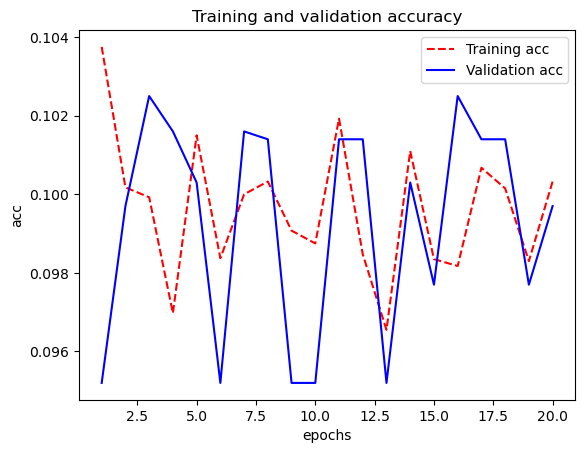

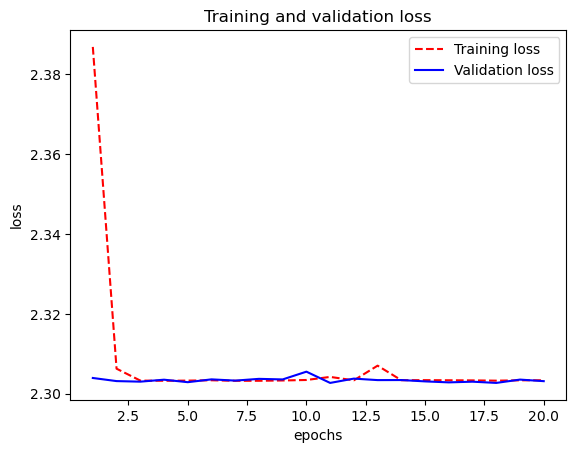

<Figure size 640x480 with 0 Axes>

In [18]:
# Result without data augmentation
model.compile(loss='categorical_crossentropy', optimizer=OPTIM1, metrics=['accuracy'])
model.summary()

history=model.fit(input_X_train, output_y_train, batch_size=BATCH_SIZE1, 
                  epochs=N_EPOCH1, validation_split=VALIDATION_SPLIT1, verbose=VERBOSE1)


plot_history(history)
test_loss,test_acc=model.evaluate(input_X_test, output_y_test, verbose=2)

print("test accuracy: ",test_acc)

In [14]:
# Result with data augmentation
model.compile(loss='categorical_crossentropy', optimizer=OPTIM1, metrics=['accuracy'])
model.summary()

history=model.fit(input_X_train_aug, output_y_train, batch_size=BATCH_SIZE1, 
                  epochs=N_EPOCH1, validation_split=VALIDATION_SPLIT1, verbose=VERBOSE1)


plot_history(history)
test_loss,test_acc=model.evaluate(input_X_test, output_y_test, verbose=2)

print("test accuracy: ",test_acc)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                        

## Trial 2

In [ ]:
#training constants
BATCH_SIZE1 = 128
N_EPOCH1 = 20 # use 20 for best initial results
VERBOSE1 = 1
VALIDATION_SPLIT1 = 0.2
learning_rate1 = 0.01
OPTIM1 = RMSprop(learning_rate = learning_rate1)
KERNEL = (5,5)

print('Main variables initialised.')

## Trial 3

In [ ]:
#training constants
BATCH_SIZE1 = 128
N_EPOCH1 = 20 # use 20 for best initial results
VERBOSE1 = 1
VALIDATION_SPLIT1 = 0.2
learning_rate1 = 0.01
OPTIM1 = RMSprop(learning_rate = learning_rate1)
KERNEL = (3,3)

print('Main variables initialised.')